# Overview

In the last lab, we computed event-related averages for responses to different categories of objects. We saw that response in fMRI emerge slowly (2-3 TRs or 4-6 seconds) after the onset of a stimulus. Fundamentally, the most common thing that we want to know in fMRI experiments is how some event is related to brain responses. The event related averages show us that some areas of the brain respond more to some stimuli than others, but we would like a more firm statistical basis before we draw any conclusions from our data. This week, we will introduce multiple regression as a way to model brain signals.

# Goals

First, we will show you how to account for the delay in the fMRI signal after a stimulus or other event. 

Second, we will show you how regression is used to evaluate how different kinds of events in a stimulus are related to a brain signal. More formally speaking, we will model a (fake) brain signal as a function of a set of regressors or independent variables in an experimental design matrix. 

In [3]:
# Imports
import neurods
import numpy as np
import matplotlib.pyplot as plt
# Configure defaults for plots
# (This is overkill, perhaps, but good tips to show.)
import matplotlib
from cycler import cycler
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.aspect'] = 'auto'
matplotlib.rcParams['image.cmap'] = 'viridis'
# New defaults!
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', ['k','r', (0,0,0.8),(0.95,0.8,0),(0,.8,0),(1.0, 0.5, 0)])

ImportError: No module named neurods

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# fMRI responses do not occur immediately after a stimulus

fMRI responses emerge slowly after the onset of a stimulus (or any other event). This means that, if we want to make an accurate mathematical model of how the brain responds, we have to somehow incorporate this delay into our model. 

To do this, we will borrow a concept from signal processing theory called the impulse response function. An impulse response function describes the way a signal emerges (for any system) after an event. The way the BOLD response emerges after an experimental event is called the *hemodynamic response function* or HRF. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event. **[NEED REFERENCES]** We will rely on the conclusions of this research without going into great detail about it. The practical upshot is that BOLD responses have a fairly characteristic shape, which is well described by a mathematical function called a *gamma function*. 

We have provided you with a function to produce this canonical HRF within the neurods module: 

    neurods.fmri.hrf()

hrf_1 shape is (32,)


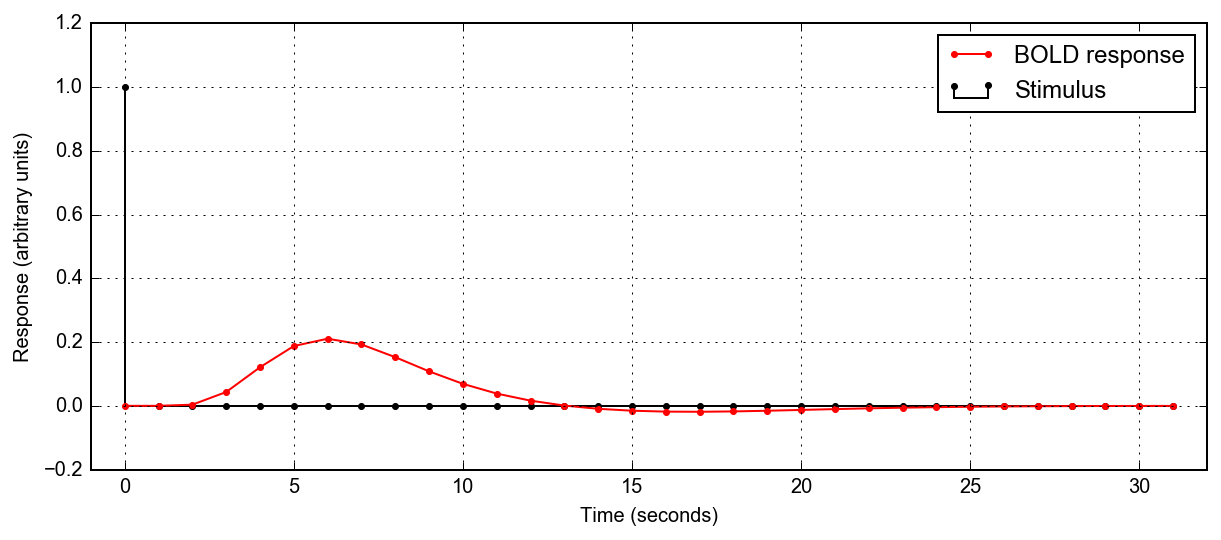

In [4]:
# Set the TR, or repetition time, a.k.a. the sampling rate for our data
TR = 1.0 # One measurement per second
# Get a canonical hrf_1
t, hrf_1 = neurods.fmri.hrf(tr=TR)
print('hrf_1 shape is', hrf_1.shape)
# This is a response to a single discrete stimulus, like this:
stimulus = np.zeros(t.shape)
stimulus[0] = 1

# We will be plotting stimulus / response pairs several times, so let's 
# just make a function for this right away.
def stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2)):
    """Plot stimulus and response"""
    plt.figure(figsize=(10,4))
    # Note stem() function!
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')
    plt.plot(t, response, 'r.-', label='BOLD response')
    plt.ylim(yl)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend()

# Plot
stim_resp_plot(t, stimulus, hrf_1)

Play with the parameters of the hrf() function. See what happens if you change them. 

In [ ]:
### STUDENT ANSWER
# hrf_01 = neurods.fmri.hrf(blah=1, blah2=2, ...)
# ETC...

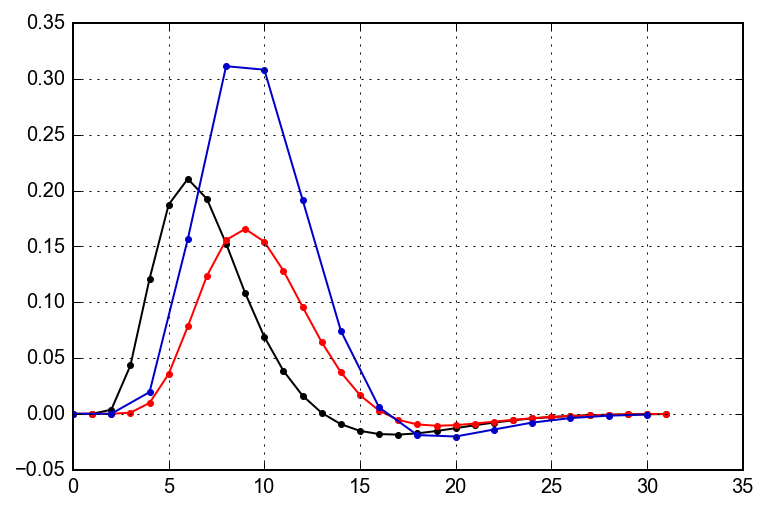

In [5]:
### STUDENT ANSWER
pkw = dict(marker='.')
plt.plot(*neurods.fmri.hrf(), **pkw)
plt.plot(*neurods.fmri.hrf(pttp=8), **pkw)
plt.plot(*neurods.fmri.hrf(pttp=8, tr=2), **pkw)

Every time an event occurs, this slow hemodynamic response emerges. The way we model this is by *convolving* the HRF with the time series of stimulus events. *Convolution* is an operation that multiplies one function by another, or for our purposes, one vector by another in elementwise fashion. (We're going to stick with intuitive descriptions rather than formal mathematical descriptions, so we beg the pardon of any mathematical purists). The two functions are matched up with each other, element for element, centered on a particular point; the values for corresponding time points are multiplied by each other; and all these products are summed up to produce a single value for that point in time. This operation is then repeated centered on the next point in one of the two functions. This probably sounds like gobbledygook to you if you're not familiar with convolution already, so let's illustrate the principle with a picture: 

<img src="wikipedia_box_convolution.gif">



In [6]:
# Demo of use of np.convolve w/ block, other shapes
# Point out that we need to crop output of convolution to match length of original signal, explain why

In [2]:
n = 200 # Total time points (TRs)
t = np.arange(n,)
activity = zeros((n))
stimuli = []
stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2))


NameError: name 'np' is not defined

Let's look at a convolution of a simple signal with the HRF function.

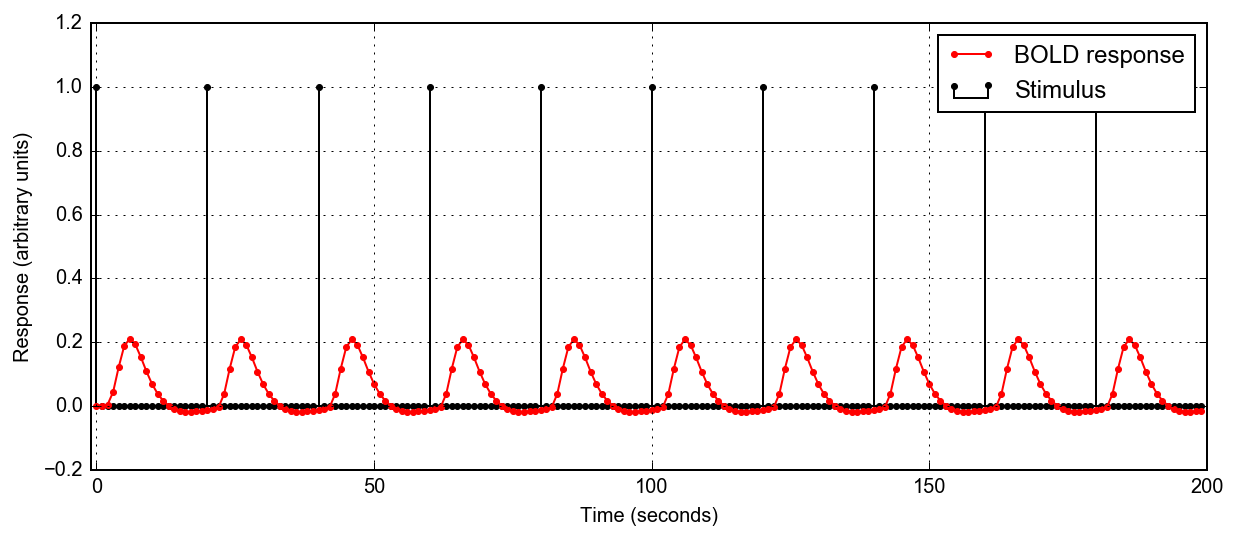

In [7]:
n = 200 # Total time points (TRs)
t = np.arange(n,)
multi_stim1 = np.zeros((n,))
multi_stim1[::20] = 1 # Set an event every 20 TRs
multi_resp1 = np.convolve(multi_stim1, hrf_1, mode='full')
stim_resp_plot(t, multi_stim1, multi_resp1[:n])

> What happens if events are close together? 

Let's construct a different time series of events to find out. 

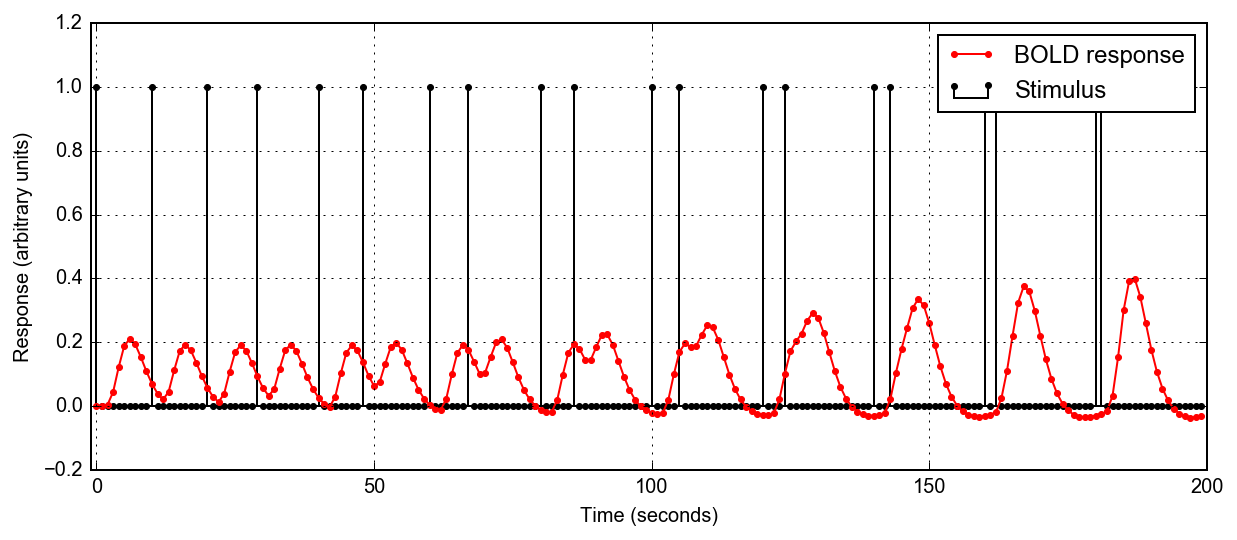

In [8]:
n = 200
t = np.arange(n,)
multi_stim2 = np.zeros((n,))
idx = np.arange(0, n, 20)
multi_stim2[idx] = 1
# add another set of events temporally close to the first ones.
add = np.arange(len(idx), 0, -1)
multi_stim2[idx+add] = 1 
multi_resp2 = np.convolve(multi_stim2, hrf_1, mode='full')
stim_resp_plot(t, multi_stim2, multi_resp2[:n])

What's going on here? Why is this important for fMRI?

> Discuss.

Next, we will show you two ways to account for this delay when trying to assess the relationship between brain signals and stimulus events. 

## Load example data

For these exercises, we will work with simulated data from a single voxel.

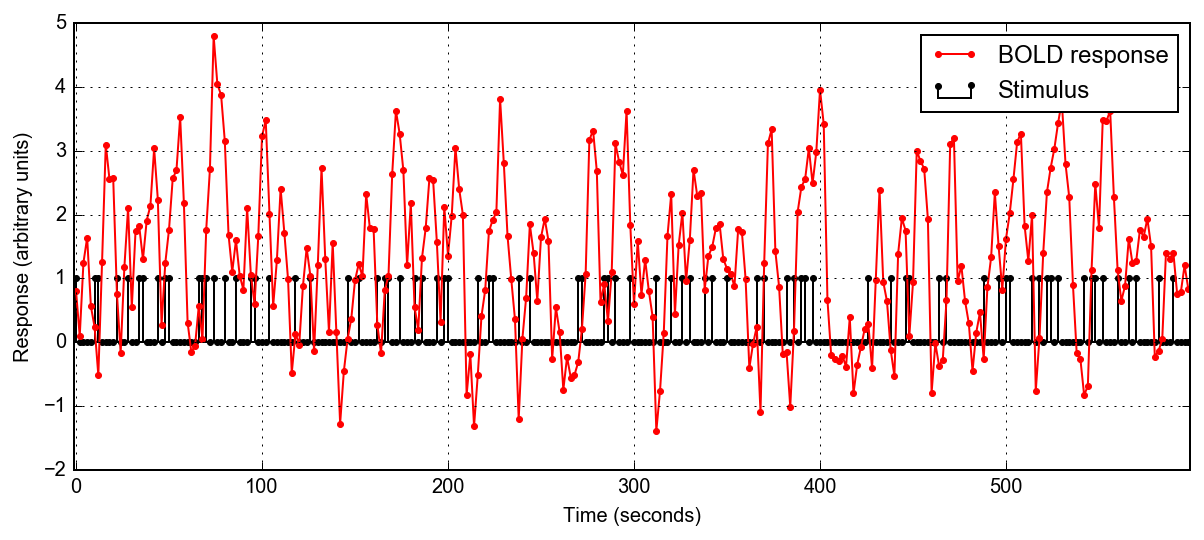

In [8]:
# Load example data
ex_data = np.load('example_data_01.npz')
t = ex_data['t']
x = ex_data['x']
data_sing = ex_data['data']
stim_resp_plot(t, x, data_sing, yl=(-2, 5))

*Instructor notes: Note that the data has larger variation than previous examples. We *COULD* z-score it... Or just leave it alone.*

Because of the hemodynamic delay, the fMRI resopnse is *NOT* correlated with the stimulus events:

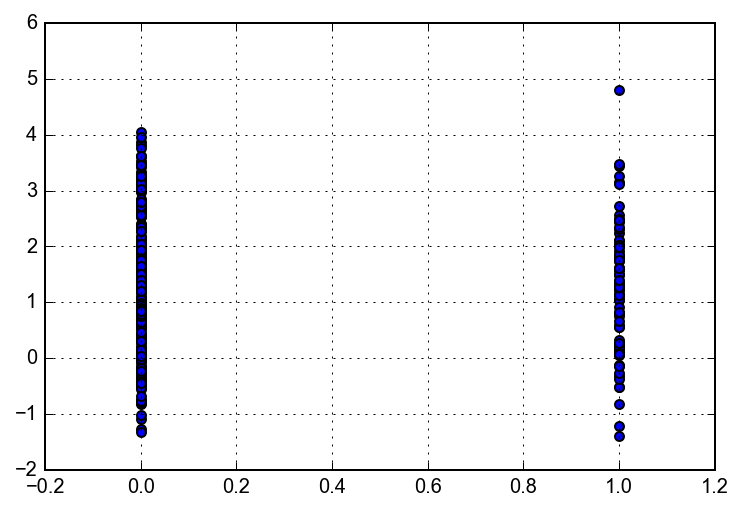

In [9]:
plt.scatter(x, data_sing)

/Users/mark/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


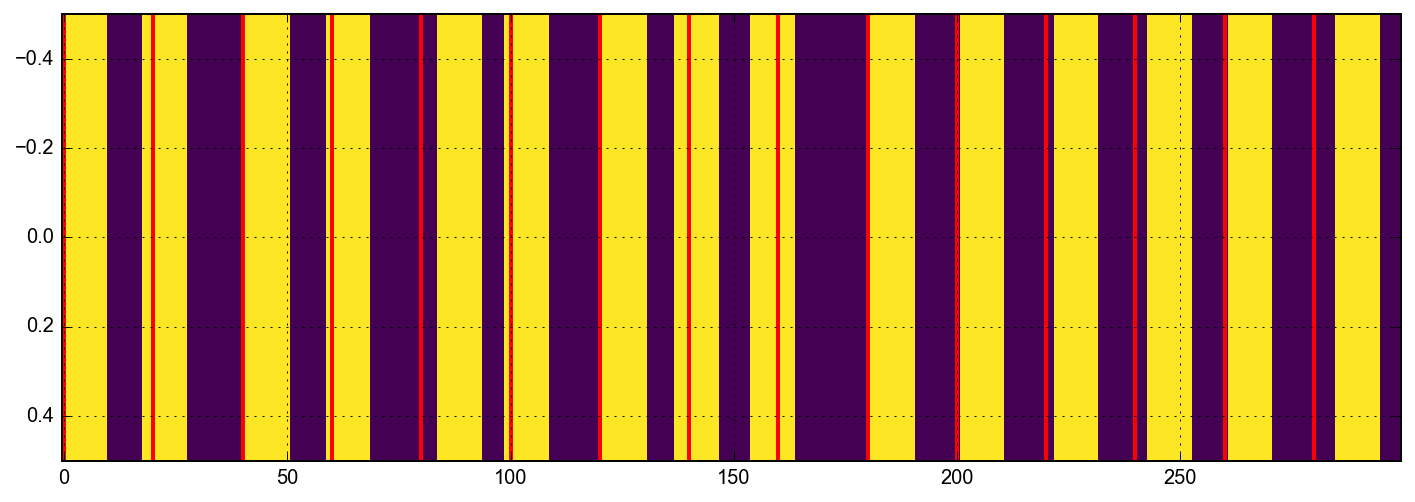

In [17]:
# Extra: What if we put all our events together in blocks? 
n_tps = 300
n_Bs = 1
X = np.zeros((n_tps,))
# Say, 10 TR events, spaced approximately every 20 TRs
spacing = 20 # TRs
block_length = 10
onsets = np.arange(0, n_tps, spacing)
# add some jitter
jitter_std = 3
jitter = np.round(np.random.randn(len(onsets), ) * jitter_std)
onsets_jittered = onsets + jitter
# Fill blocks
for o in onsets_jittered:
    X[o:o+block_length] = 1
plt.figure(figsize=(12,4))
plt.imshow(X[None,:])
plt.vlines(onsets, -0.5, 0.5, color='r', lw=2)

In [20]:
t2, hrf_2 = neurods.fmri.hrf(tr=2)

In [21]:
Xh = np.convolve(X, hrf_2, mode='full')[:n_tps]

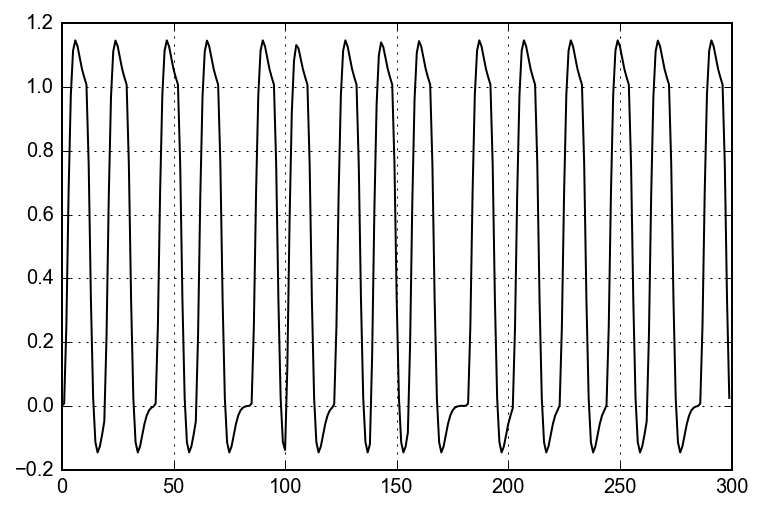

In [23]:
plt.plot(Xh)

In [24]:
noise_std = 0.3
noise = np.random.randn(n_tps)*noise_std

In [ ]:
Yblock = Xh*Bblock + noise_std

In [10]:
np.corrcoef(x, data_sing)[0,1]

-0.028809773937839171

... and if we use simple regression to try to extract the relationship between the stimulus events and the brain responses, we find something: 

# TODO: Need more regression review!

In [11]:
from sklearn import linear_model as lm

In [12]:
reg_sing = lm.LinearRegression(fit_intercept=False)
reg_sing.fit(x[:,np.newaxis], data_sing[:,np.newaxis])
print('Regression coefficient: ',reg_sing.coef_)

Regression coefficient:  [[ 1.21194475]]


... however, this value does not provide a good description of our data. To show that, let's see how well the fit regression model describes the data.

In [13]:
# Compute R^2 for regression: (Perhaps not... Is this in the class?)
reg_sing.score(x[:,np.newaxis], data_sing[:,np.newaxis]) # replace with np.newaxis? Do we care? 
# PS newaxis is really just None
assert np.newaxis is None, 'Mark is a liar!'

In [14]:
data_sing_pred = reg_sing.predict(x[:,np.newaxis])

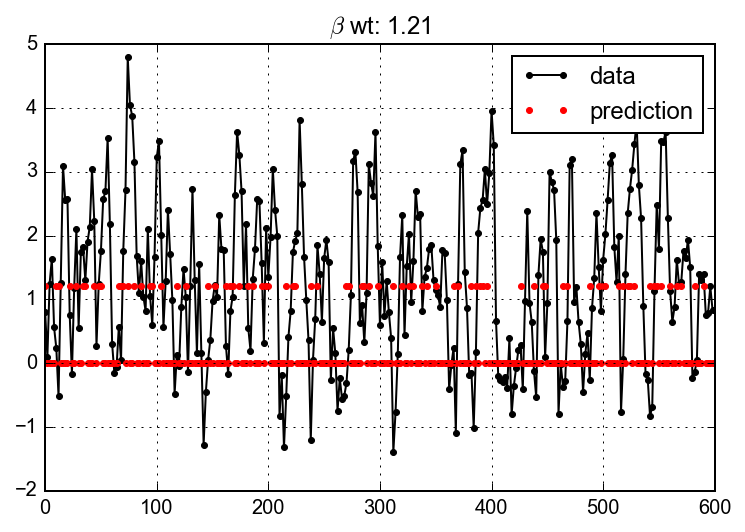

In [15]:
plt.plot(t, data_sing, '.-', label='data')
plt.plot(t, data_sing_pred, '.', label='prediction')
plt.title('$\\beta$ wt: {:.2f}'.format(reg_sing.coef_[0,0]))
_ = plt.legend()

Why are there only two values of predictions here? (because design matrix is binary)

BUT, if we convolve the design matrix (x) by the hrf, then we get much better results:

In [16]:
n_tps = len(data_sing)
# Get HRF
TR = 2.0
t, hrf_2 = neurods.fmri.hrf(tr=TR)
# Convolve HRF with stimulus timecourse
xh = np.convolve(x, hrf_2, mode='full')[:n_tps]

(-0.2, 1.2)

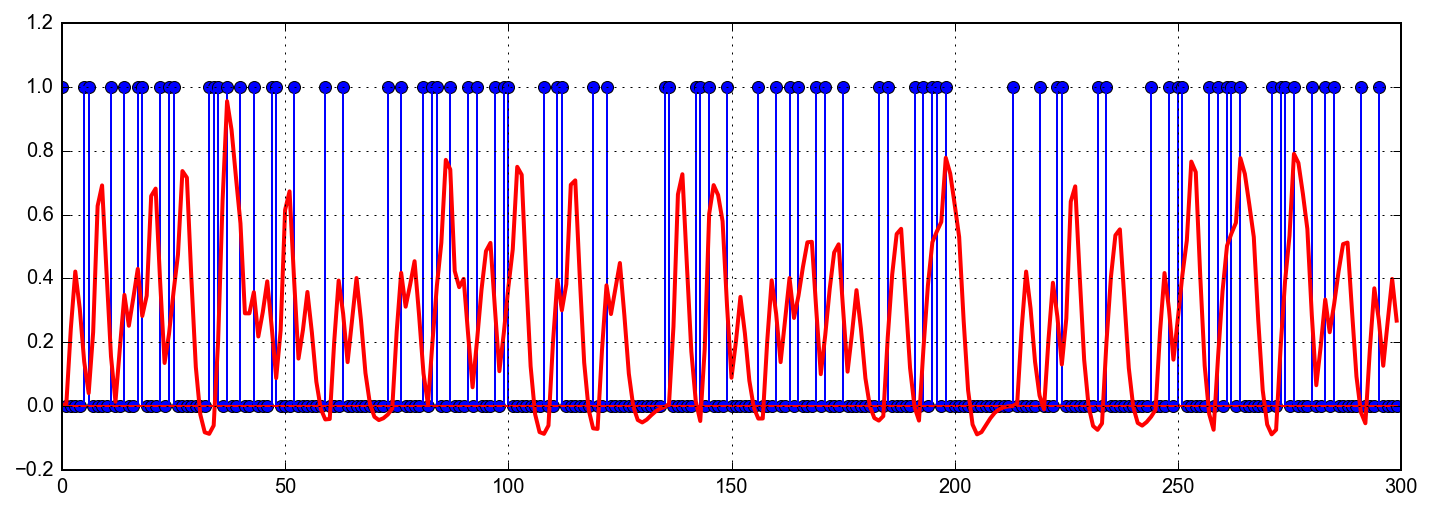

In [22]:
plt.figure(figsize=(12,4))
plt.stem(x)
plt.plot(xh, 'r', lw=2)
plt.ylim(-0.2,1.2)

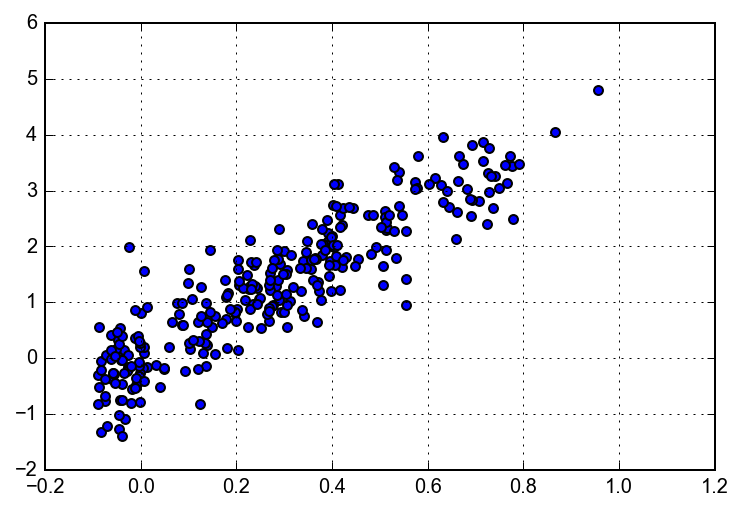

In [23]:
plt.scatter(xh, data_sing)

In [ ]:
### TEACHER INFO

# note: this is more similar to what they will have seen in the regression lecture in class: thus, play with the 
# scaling constant on the xh variable to minimize the error (bring the stimulus (black) dots closer to the 
# data (red) line)

In [ ]:
### STUDENT ANSWER


In [3]:
plt.figure(figsize=(12,4))
plt.plot(xh*1)
plt.plot(data_sing, 'r.--')

NameError: name 'xh' is not defined

In [24]:
np.corrcoef(data_sing, xh)[0,1]

0.90628828745838708

In [25]:
reg_sing_hrf = lm.LinearRegression(fit_intercept=False)
reg_sing_hrf.fit(xh[:,np.newaxis], data_sing[:,np.newaxis])
print(reg_sing_hrf.coef_)

[[ 4.62868177]]


Test fit by predicting the same data:

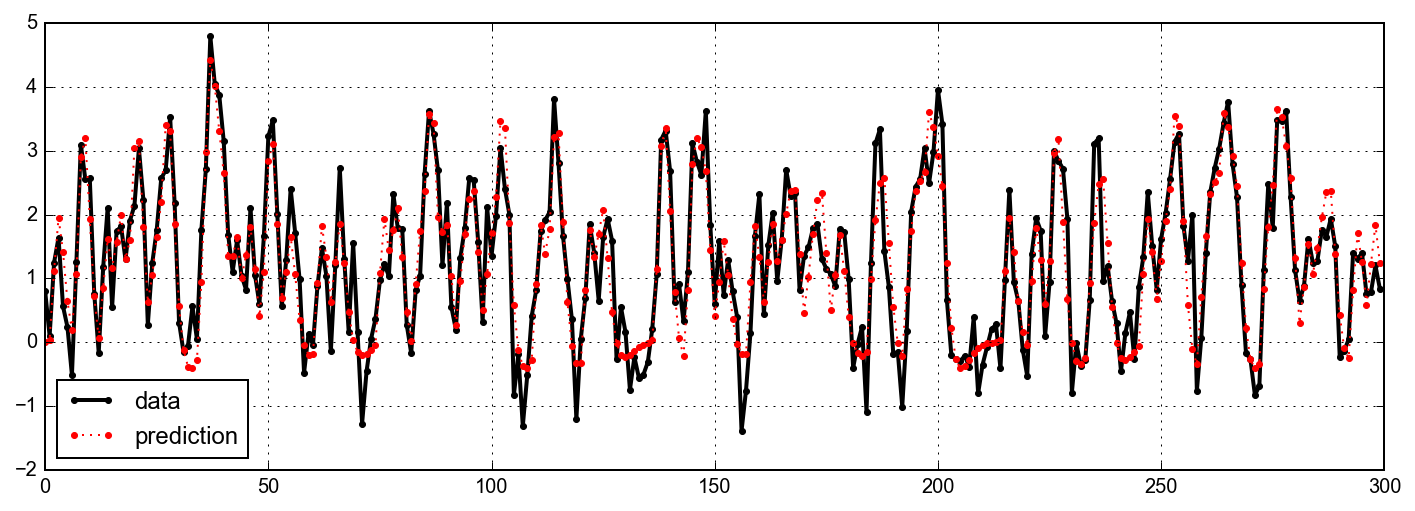

In [29]:
fig = plt.figure(figsize=(12,4))
data_sing_pred2 = reg_sing_hrf.predict(xh[:,np.newaxis])
idx = np.argsort(data_sing)
plt.plot(data_sing, '.-', linewidth=2, label='data')
plt.plot(data_sing_pred2, '.:', label='prediction')
plt.legend(loc='best')

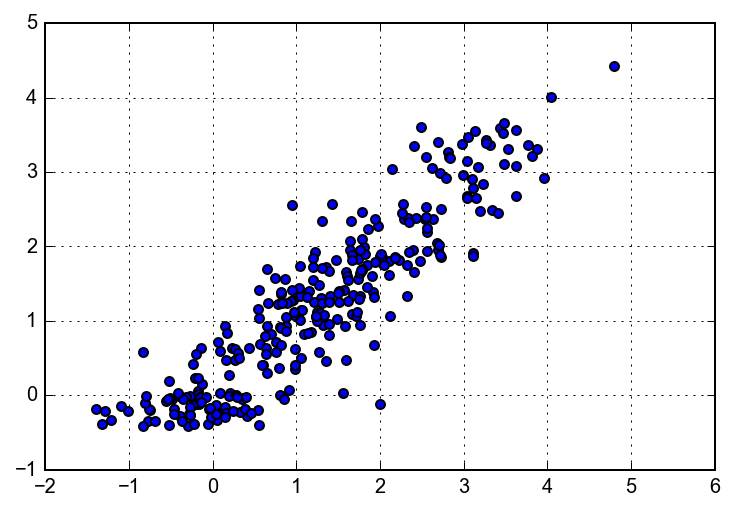

In [30]:
plt.scatter(data_sing, data_sing_pred2)

*Note: Computing errors directly won't work well without computing the intercept.*

In [31]:
# Alternatively, compute error:
print(np.sum((data_sing_pred-data_sing)**2))
print(np.sum((data_sing_pred2-data_sing)**2))

241129.608068
250349.12564


In [33]:
# Not actually sure what these do...
print(reg_sing._residues)
print(reg_sing_hrf._residues)

[ 815.15990504]
[ 80.6839074]


# Multiple regression 

Last week, we computed event-related averages for each condition or event in our stimulus. Computing averages in this way doesn't fully account for the possiblity that the brain responds to more than one thing. In order to model brain responses as a function of multiple independent variables*, we need to use multiple regression. 

The multiple regression equation is:

$Y\ =\  \Sigma_i^n x_i*\beta_i\ +\  \epsilon$

This means that, if $n$ is, say, 3 independent variables:

$Y\ =\ (X_1*\beta_1) + (X_2*\beta_2) + (X_3*\beta_3) + \epsilon\ \ $ ($\epsilon$ is noise)

To help us understand this more concretely, let's just start by making such a signal. We will build up this signal exactly as the regression equation says it is built up: as a combination of a few X variables, multiplied by $\beta$ weights, plus some noise ($\epsilon$)

*These independent variables can be experimental condition labels, features or aspects of a stimulus, brain states, whatever. 

In [34]:
# Parameters for construction of fake data
n_tps = 300 # number of TRs
n_Bs = 3 # number of betas / independent variables to go into our data
noise_std = 0.3 # how much noise should there be
TR = 2.0 # TR for this fake experiment
B = np.array([0.56, -1.3, 2.8]) # the weight for each of our independent variables

We need some (simulated, fake) timecourse of events on which our simulated brain response will be based. 

We will create this as a matrix of ones and zeros, of `n_tps` x `n_Bs` (the number of time points x the number of different kinds of events that influence our signal).

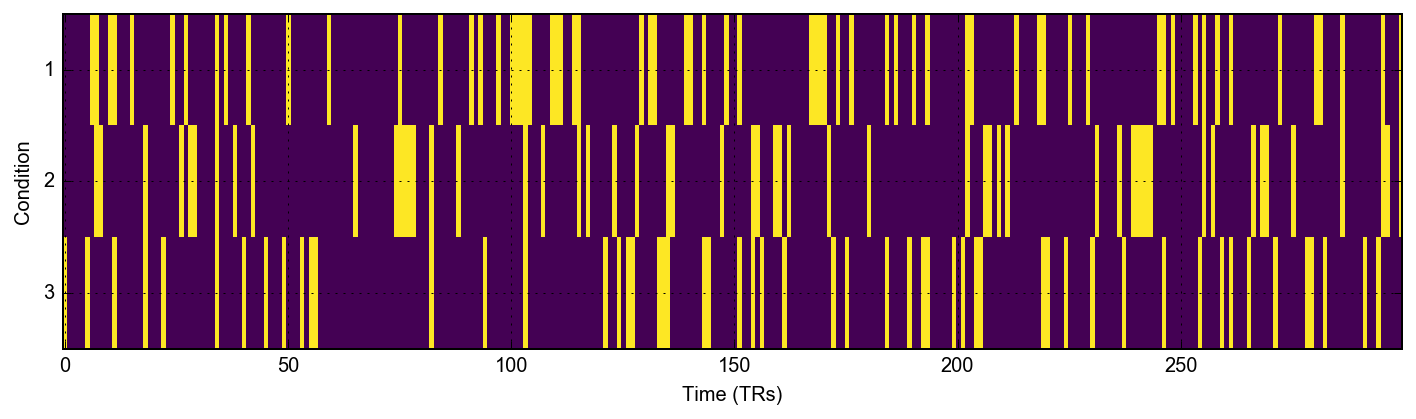

In [52]:
# For our design matrix, we're going to create a random design of single-TR events. 
X = np.random.rand(n_tps, n_Bs) > 0.8
X = X.astype(np.float32) # Don't want this to be a boolean type
# Let's see what this did:
plt.figure(figsize=(12,3))
plt.imshow(X.T)
plt.xlabel('Time (TRs)')
plt.ylabel('Condition')
_ = plt.yticks([0,1,2], [1,2,3])

> How would you create fewer events per condition in X? More events per condition?

In [53]:
# And the noise:
noise = np.random.randn(n_tps)*noise_std

*Make a function to show design matrices?*

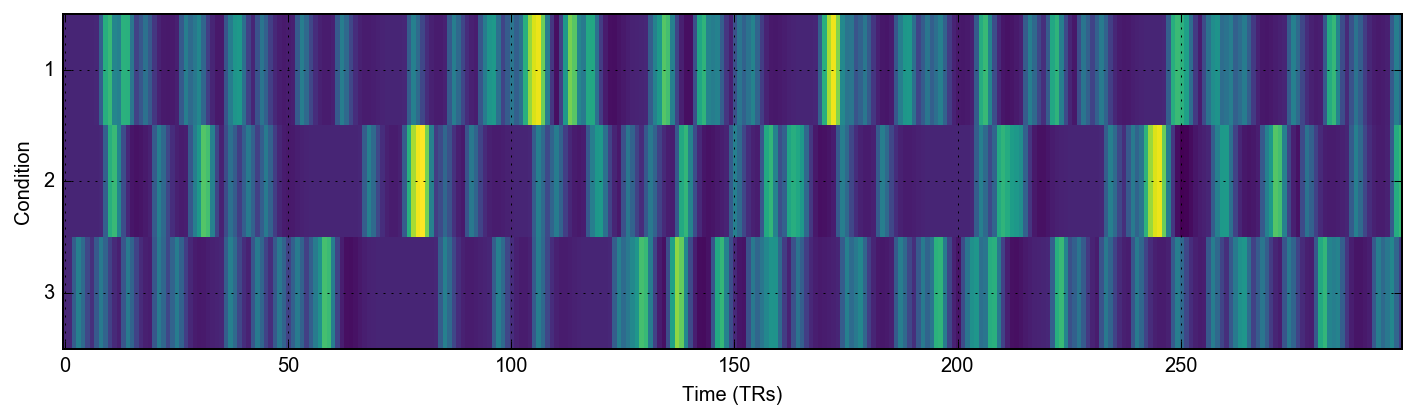

In [54]:
# Apply HRF to X (design matrix):
Xh = np.array([np.convolve(x, hrf_2)[:len(x)] for x in X.T]).T
plt.figure(figsize=(12,3))
plt.imshow(Xh.T)
plt.xlabel('Time (TRs)')
plt.ylabel('Condition')
_ = plt.yticks([0,1,2], [1,2,3])

In [55]:
Xh.shape

(300, 3)

In [56]:
B[:,np.newaxis].shape

(3, 1)

# SHOULD BE 3 CELLS

In [57]:
# OK, now the data: 
# Easy-to-understand way first
signal_1 = Xh[:,0]*B[0] + Xh[:,1]*B[1] + Xh[:,2]*B[2] + noise
# Fancier, list comprehension way
signal_2 = np.sum(np.vstack([x*b for x, b in zip(Xh.T, B)]), axis=0) + noise
# Super fancy linear algebra way
signal_3 = Xh.dot(B[:,np.newaxis]) + noise[:, np.newaxis]
# (get rid of 2nd dimension, which is just 1 anyway)
signal_3 = signal_3.flatten()

In [58]:
# All same! 
assert np.allclose(signal_1, signal_2), 'If you see this message, your teacher is a liar!'
assert np.allclose(signal_1, signal_3), 'If you see this message, your teacher is a liar!'

[Computational tutorial on floating point precision] possibly not worth noting here...

False


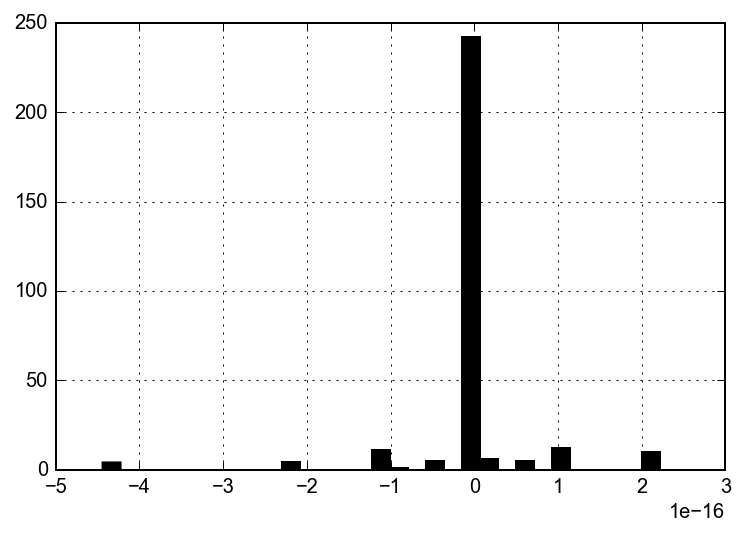

In [59]:
# Note that technically the two are not equal:
print(np.all(signal_1==signal_3))
# ... But they're really close to equal. Note the scale of differences on the x axis.
# a few values are 10^-15 away from zero.
_ = plt.hist(signal_1-signal_3, 31)
# This is exactly what np.all_close was made for. 

Let's see what we've created:

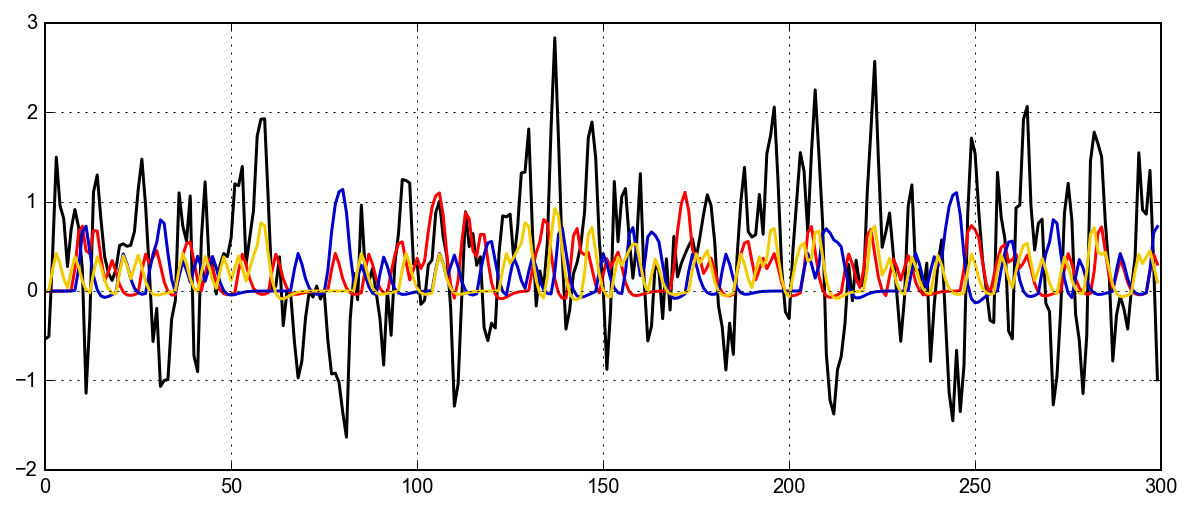

In [60]:
plt.figure(figsize=(10,4))
plt.plot(signal_1, label='Signal', lw=1.5)
plt.plot(Xh, lw=1.5)

Looks like brain data, right? 

Let's see if we can recover the inputs. 

In [61]:
reg_multi = lm.LinearRegression(fit_intercept=False)
reg_multi.fit(Xh, signal_1[:,np.newaxis])
print(B)
print(reg_multi.coef_)

[ 0.56 -1.3   2.8 ]
[[ 0.55176024 -1.28954928  2.68629678]]


Not bad.

# Maybe stop here, skip straight to HW
or:

## Using multiple regression to compute the hemodynamic response function
Another use for multiple regression is to compute full hemodynamic response functions for each voxel.

We will illustrate this with the original fake data set. 

In [63]:
# First, we will demonstrate why you can't just use event-related averaging. 
ev_avg = neurods.fmri.compute_event_avg(data_sing, np.nonzero(x>0)[0], 15)

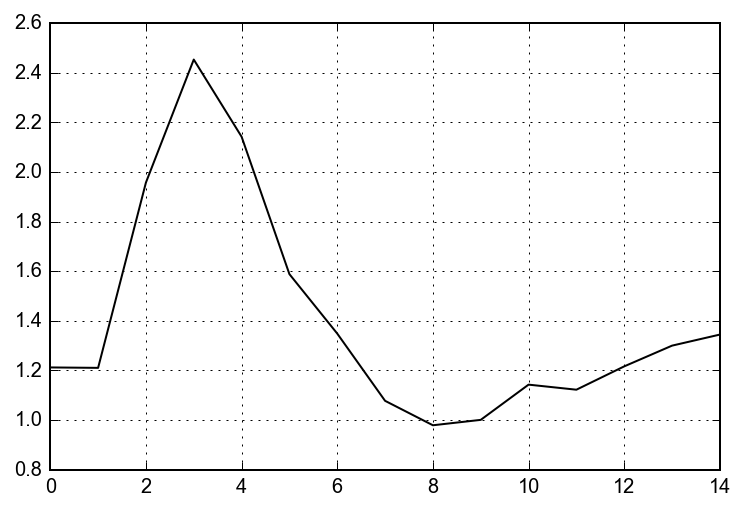

In [64]:
# Not bad. 
plt.plot(ev_avg)

Chris points out that this is actually UNDER estimating, if you take the base-to-peak distance.

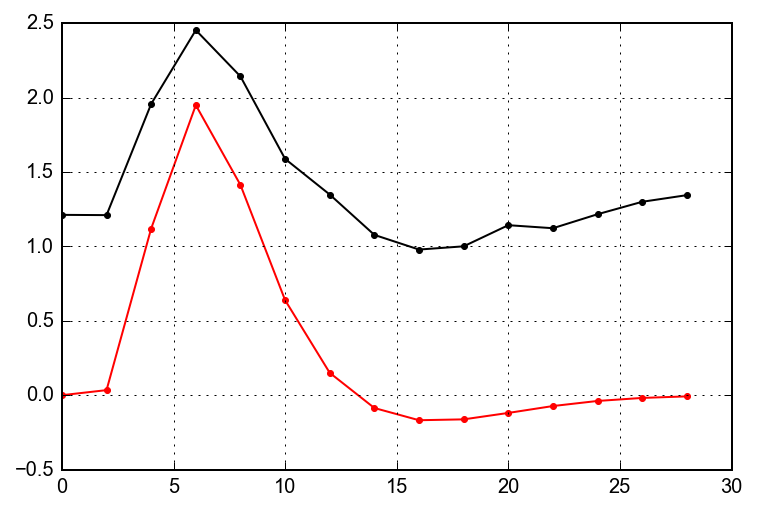

In [65]:
# ... but it over-estimates the magnitude of the HRF. 
plt.plot(t[:15], ev_avg, '.-')
# Note: We found above that there was a non-zero regression coefficient for this condition, so multiply the HRF by that.
plt.plot(t[:15], hrf_2[:15]*reg_sing_hrf.coef_[0], '.-') 

(be explicit about how you compute lags here, use library neurods function later)

In [66]:
x_lag = neurods.fmri.add_lags(x[:,np.newaxis], range(15))
x_lag.shape

(300, 15)

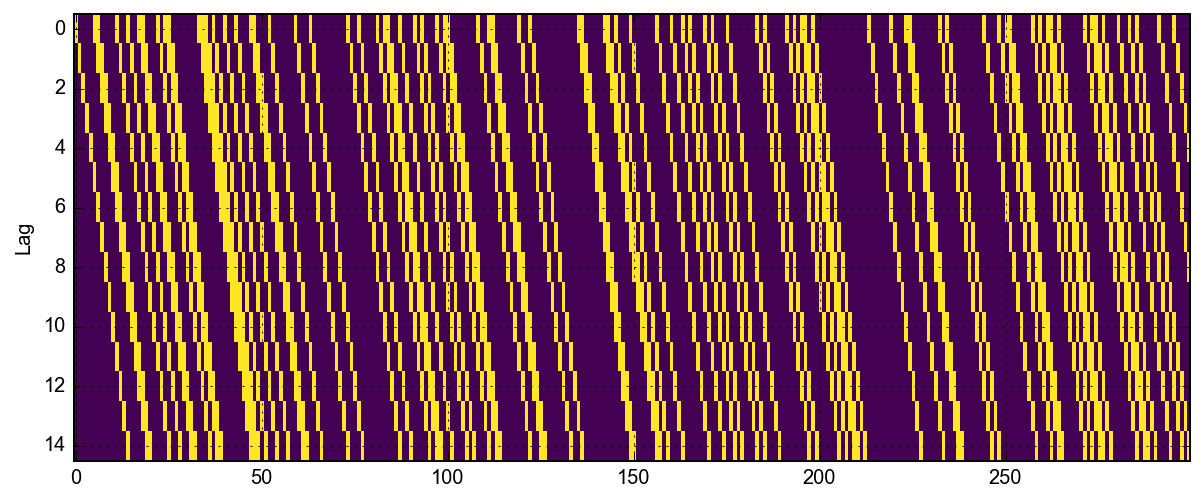

In [67]:
plt.figure(figsize=(10,4))
plt.imshow(x_lag.T)
plt.ylabel('Lag')

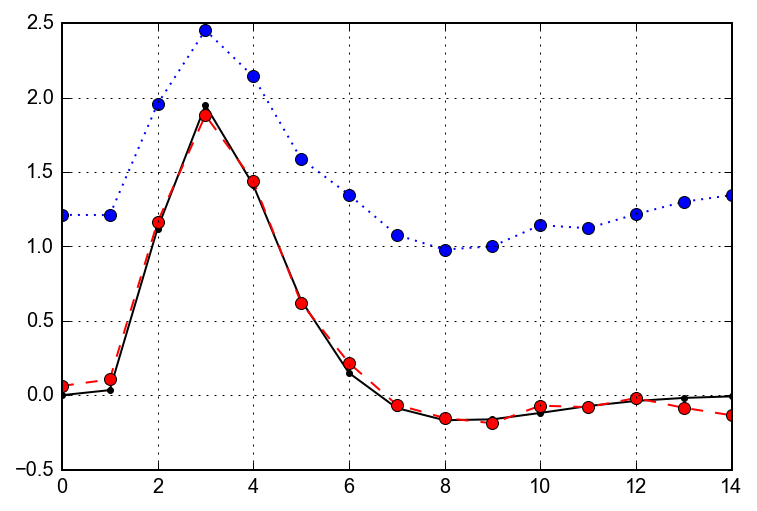

In [68]:
reg_hrf = lm.LinearRegression()
reg_hrf.fit(x_lag, data_sing)

plt.plot(hrf_2[:15]*reg_sing_hrf.coef_[0], 'k.-')
plt.plot(ev_avg, 'bo:')
plt.plot(reg_hrf.coef_.T, 'ro--')

We can do the same trick with multiple independent variables, too, if we add lags (FIR predictors) to each condition:

In [69]:
X_lag = neurods.fmri.add_lags(X, range(10), is_interleaved=True)

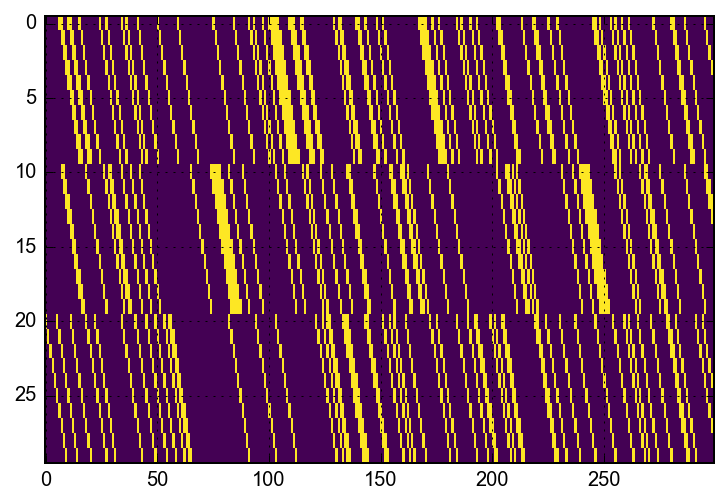

In [70]:
plt.imshow(X_lag.T)

In [71]:
reg_fir_3cond = lm.LinearRegression(fit_intercept=False)

In [72]:
reg_fir_3cond.fit(X_lag, signal_1)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

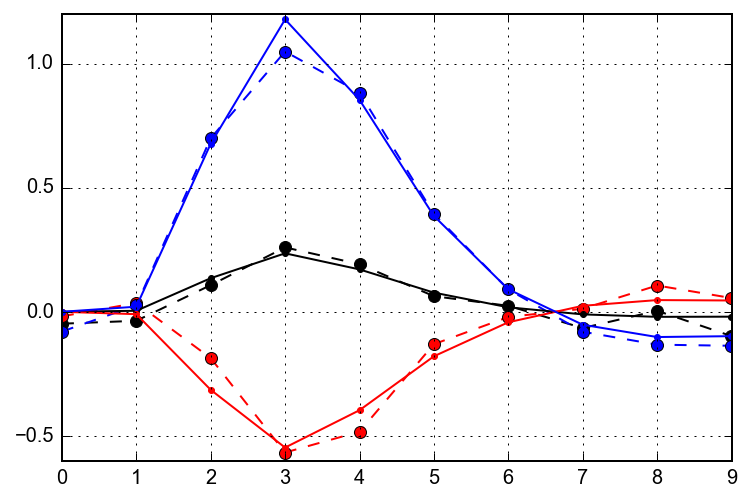

In [73]:
# Regression weights
plt.plot(reg_fir_3cond.coef_[:10],'ko--')
plt.plot(reg_fir_3cond.coef_[10:20],'ro--')
plt.plot(reg_fir_3cond.coef_[20:30], 'bo--')
# HRFs, scaled by true betas that generated data
plt.plot(hrf_2[:10]*B[0], 'k.-')
plt.plot(hrf_2[:10]*B[1], 'r.-')
plt.plot(hrf_2[:10]*B[2], 'b.-')

Make sure we define FIR above

---

# Lab / Homework
(or lab)

(1) Write a function to apply the hemodynamic response function to a design matrix. *(easy peasy)*

(2) Write a function to add FIR lags to a design matrix. *(easy peasy)*

(3) Write a function that generates fake data according to a set of parameters (including `n_tps`, `n_channels`, and `noise_std`, and `B`, as we used above, and as many more as you can think of that may be interesting to vary). 

Try to generate a data set for which you can't recover the B weights that generated the data (hint: add noise). 

Besides just adding a ton of noise, can you find other ways to stump the regression algorithm? 

Make plots of how changing a parameter leads to better or worse performance of the regression (put different values for one of your parameters on the x axis, and some value of . What you plot - i.e. how you measure how well the regression is performing - is up to you. 

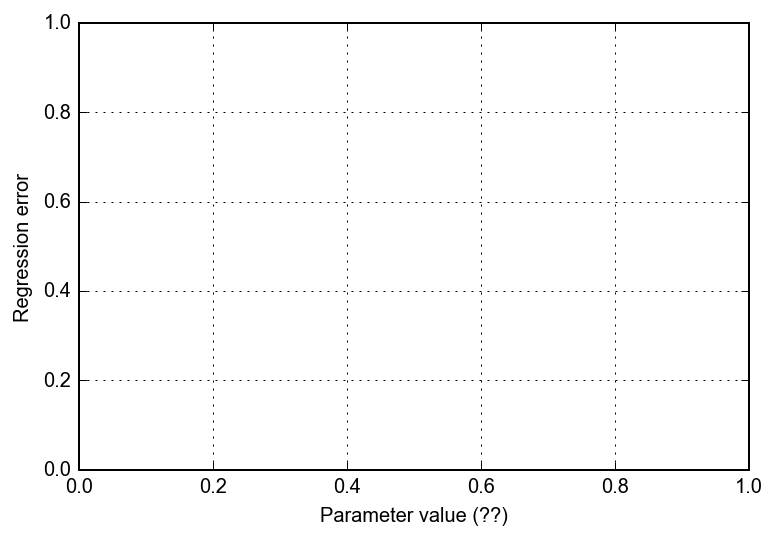

In [74]:
plt.plot(np.nan, np.nan)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Parameter value (??)')
plt.ylabel('Regression error')